<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1 Mount to Google Drive

The complete computation is done on Google Colab. The following code mounts the Google Drive to the Colab environment.

In [1]:
# mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2 Import relevant libraries and define relevant paths

In [2]:
# for opening installed packages (installed in virtual environment of Google Colab)
import sys
sys.path.append('/content/drive/MyDrive/colab_env/lib/python3.10/site-packages')
# for importing modules defined in other jupyter notebooks
import import_ipynb
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis'

/content/drive/MyDrive/cbs/master_thesis/master-thesis


In [5]:
# import relevant libraries

import os # for file handling
import glob # for file handling
import random # generate random numbers and seed setting
from tqdm import tqdm # for counter

import numpy as np # for data manipulation
import matplotlib.pyplot as plt # for plotting

from PIL import Image # read and save images
from patchify import patchify, unpatchify # for getting patches and 'unpatchifying'

import torch # for PyTorch framework
import torchvision.transforms.functional as TF # for tensor transformations and normalization
from torch import nn # for defining layers of unet model and resizing
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis/02_unet'
from unet_model import UNET # for U-Net architecture
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis/03_sam'
from sam_dataset import SAMDataset # custom dataset class
from sam_prompt_functions import generate_input_points # for SAM model
from transformers import SamModel, SamProcessor, SamConfig # for SAM model

from sklearn.metrics import accuracy_score, recall_score, precision_score # for evaluation
%cd '/content/drive/MyDrive/cbs/master_thesis/master-thesis/04_evaluation'
from evaluation_utils import dice_score, iou_score, calculate_metrics, sigmoid # for evaluation
from statistics import mean # calculate mean of metrics

/content/drive/MyDrive/cbs/master_thesis/master-thesis/02_unet
importing Jupyter notebook from unet_model.ipynb
/content/drive/MyDrive/cbs/master_thesis/master-thesis/03_sam
importing Jupyter notebook from sam_dataset.ipynb
importing Jupyter notebook from sam_prompt_functions.ipynb
/content/drive/MyDrive/cbs/master_thesis/master-thesis/04_evaluation
importing Jupyter notebook from evaluation_utils.ipynb


In [6]:
# define dataset path
dataset_path_unet = '/content/drive/MyDrive/cbs/master_thesis/dataset_gray'
dataset_path_sam = '/content/drive/MyDrive/cbs/master_thesis/dataset_rgb'

# define model path
model_path = '/content/drive/MyDrive/cbs/master_thesis/models'

### 3 Evaluate U-Net model on the test set

#### 3.1 Load the trained model

In [7]:
# load trained U-Net model
unet_model = UNET(in_channels=1, out_channels=1)

# load trained weights
unet_model.load_state_dict(torch.load(os.path.join(model_path, 'unet_model_1.pth')))

<All keys matched successfully>

In [8]:
# set the device to cuda if available, otherwise use cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet_model.to(device)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

#### 3.2 Visual inspection of predicted masks

In [11]:
# load validation images and masks
# get file names of validation images
images_files_test = glob.glob(os.path.join(dataset_path_unet, 'testing', 'images', '*.jpg'))
images_files_test.sort()

# get file names of validation masks
masks_files_test = glob.glob(os.path.join(dataset_path_unet, 'testing', 'masks', '*.jpg'))
masks_files_test.sort()

# select random image number
image_number = 5

# load image and mask
image = np.array(Image.open(images_files_test[image_number]).convert('L'))
y_true = np.array(Image.open(masks_files_test[image_number]).convert('1'))

# extract patches of the image
patches = patchify(image, (256, 256), step=256)

# set U-Net model to evaluation mode
unet_model.eval()
# empty list to store patches
predicted_patches = []

# go through all patches and predict mask
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i,j,:,:]
        # transform to tensors and normalize the images
        patch = TF.to_tensor(patch)
        patch = TF.normalize(patch, [0.0], [1.0])
        patch = patch.unsqueeze(0).to(device)
        with torch.no_grad():
            # predict using model
            prediction = unet_model(patch.to(device))
            # remove batch dimension
            prediction = prediction.squeeze().cpu().numpy()
        predicted_patches.append(prediction)

# reshape predicted patches to match the shape of patchify output for unpatchify
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = predicted_patches.reshape(patches.shape[0], patches.shape[1], 256, 256)

# get original mask by 'unpatchifying'
y_prob = unpatchify(predicted_patches_reshaped, (image.shape[0], image.shape[1]))
# apply sigmoid to get probabilities
y_prob = sigmoid(y_prob)
# convert to binary using threshold
y_pred_unet = (y_prob > 0.5).astype(np.float32)

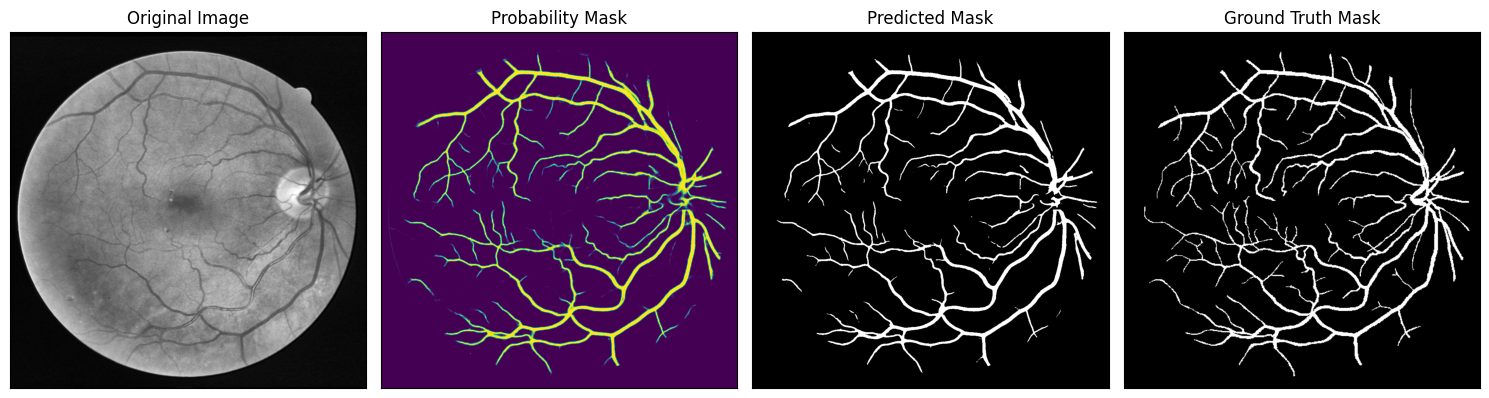

In [12]:
# visualize the results
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# plot original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')

# plot probability mask
axes[1].imshow(y_prob)
axes[1].set_title('Probability Mask')

# plot predicted mask
axes[2].imshow(y_pred_unet, cmap='gray')
axes[2].set_title('Predicted Mask')

# plot ground truth mask
axes[3].imshow(y_true, cmap='gray')
axes[3].set_title('Ground Truth Mask')

# hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# adjust spacing between subplots
plt.tight_layout()

# show the images and masks
plt.show()

#### 3.3 Evaluate with metrics

In [13]:
# empty dictionaries to store metrics
all_metrics = {}

# define thresholds to optimize
thresholds = [0.50]

# load validation images and masks
# get file names of validation images
images_files_val = glob.glob(os.path.join(dataset_path_unet, 'testing', 'images', '*.jpg'))
images_files_val.sort()

# get file names of validation masks
masks_files_val = glob.glob(os.path.join(dataset_path_unet, 'testing', 'masks', '*.jpg'))
masks_files_val.sort()

# set model to evaluation mode
unet_model.eval()

# for tqdm progress bar
total_items = len(images_files_val)

for image_path, mask_path in tqdm(zip(images_files_val, masks_files_val), total=total_items):
    # load image and mask
    image = np.array(Image.open(image_path).convert('L'))
    y_true = np.array(Image.open(mask_path).convert('1'))

    # extract patches of the image
    patches = patchify(image, (256, 256), step=256)

    # empty list to store patches
    predicted_patches = []

    # go through all patches and predict mask
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:]
            # transform to tensors and normalize the images
            patch = TF.to_tensor(patch)
            patch = TF.normalize(patch, [0.0], [1.0])
            patch = patch.unsqueeze(0).to(device)
            with torch.no_grad():
                # predict using model
                prediction = unet_model(patch.to(device))
                # remove batch dimension
                prediction = prediction.squeeze().cpu().numpy()
            predicted_patches.append(prediction)

    # reshape predicted patches to match the shape of patchify output for unpatchify
    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = predicted_patches.reshape(patches.shape[0], patches.shape[1], 256, 256)

    # get original mask by 'unpatchifying'
    y_prob = unpatchify(predicted_patches_reshaped, (image.shape[0], image.shape[1]))
    # apply sigmoid to get probabilities
    y_prob = sigmoid(y_prob)

    # calculate metrics for defined thresholds
    metrics = calculate_metrics(y_true, y_prob, thresholds)

    # aggregate metrics for all images
    for threshold, metric_values in metrics.items():
        if threshold not in all_metrics:
            all_metrics[threshold] = []
        all_metrics[threshold].append(metric_values)

# print mean metrics
for threshold, metric_values in all_metrics.items():
    print(f'\nResults for {threshold}:')
    for metric_name in metric_values[0].keys():
        mean_metric = np.mean([metric[metric_name] for metric in metric_values])
        print(f'Mean {metric_name.capitalize()}: {round(mean_metric, 4)}')

100%|██████████| 78/78 [03:01<00:00,  2.33s/it]


Results for threshold_0.5:
Mean Accuracy: 0.9753
Mean Precision: 0.8562
Mean Recall: 0.8303
Mean Dice: 0.8401
Mean Iou: 0.7343


### 4 Evaluate SAM model on the test set

#### 4.1 Load the trained model

In [14]:
# load SAM model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# create instance of the model architecture with the loaded configuration
sam_model = SamModel(config=model_config)
# load fine-tuned weights
sam_model.load_state_dict(torch.load(os.path.join(model_path, 'sam_model_3.pth')))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

<All keys matched successfully>

In [15]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

#### 4.2 Visual inspection of predicted masks

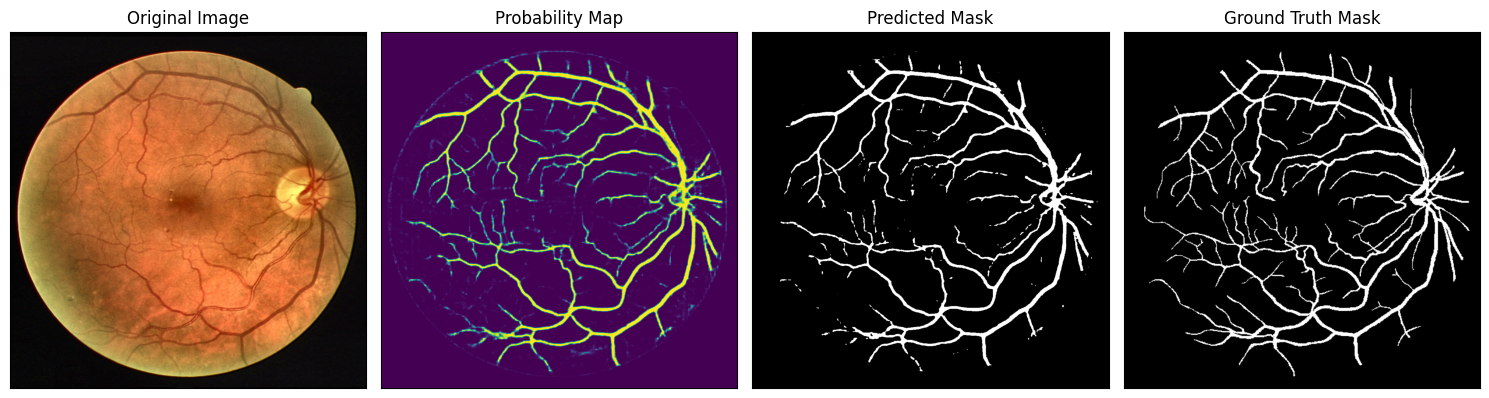

In [16]:
# load validation images and masks
# get file names of validation images
images_files_test = glob.glob(os.path.join(dataset_path_sam, 'testing', 'images', '*.jpg'))
images_files_test.sort()

# get file names of validation masks
masks_files_test = glob.glob(os.path.join(dataset_path_sam, 'testing', 'masks', '*.jpg'))
masks_files_test.sort()

# select random image number
image_number = 5

# load image and mask
image = np.array(Image.open(images_files_test[image_number]).convert('RGB'))
y_true = np.array(Image.open(masks_files_test[image_number]).convert('1'))

# define input points
input_points = generate_input_points()

# use input points as prompts for better result
inputs = processor(image, input_points=input_points, return_tensors="pt")

# input tensor to GPU if available
inputs = {k: v.to(device) for k, v in inputs.items()}
# set SAM model to evaluation mode
sam_model.eval()


# forward pass
with torch.no_grad():
  outputs = sam_model(**inputs, multimask_output=False)
  # reshape as masks outputs are 256x256
  outputs = nn.functional.interpolate(outputs.pred_masks.squeeze(1),
                                      size=(1024, 1024),
                                      mode='bilinear',
                                      align_corners=False)

# apply sigmoid
y_prob = torch.sigmoid(outputs)
# convert soft mask to hard mask
y_prob = y_prob.cpu().numpy().squeeze()
# convert to binary using threshold
y_pred_sam = (y_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(image, cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title('Original Image')

# Plot the second image on the right
axes[1].imshow(y_prob)  # Assuming the second image is grayscale
axes[1].set_title('Probability Map')

# Plot the second image on the right
axes[2].imshow(y_pred_sam, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title('Predicted Mask')

# Plot the second image on the right
axes[3].imshow(y_true, cmap='gray')  # Assuming the second image is grayscale
axes[3].set_title('Ground Truth Mask')

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# adjust spacing between subplots
plt.tight_layout()

# Display the images side by side
plt.show()

#### 4.3 Evaluate with metrics

In [17]:
# empty dictionaries to store metrics
all_metrics = {}

# define thresholds to optimize
thresholds = [0.50]

# load validation images and masks
# get file names of validation images
images_files_val = glob.glob(os.path.join(dataset_path_sam, 'testing', 'images', '*.jpg'))
images_files_val.sort()

# get file names of validation masks
masks_files_val = glob.glob(os.path.join(dataset_path_sam, 'testing', 'masks', '*.jpg'))
masks_files_val.sort()

# set model to evaluation mode
sam_model.eval()

# for tqdm progress bar
total_items = len(images_files_val)

for image_path, mask_path in tqdm(zip(images_files_val, masks_files_val), total=total_items):
    # load image and mask
    image = np.array(Image.open(image_path).convert('RGB'))
    y_true = np.array(Image.open(mask_path).convert('1'))

    # define input points
    input_points = generate_input_points()

    # use input points as prompts for better result
    inputs = processor(image, input_points=input_points, return_tensors="pt")

    # input tensor to GPU if available
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # forward pass
    with torch.no_grad():
      outputs = sam_model(**inputs, multimask_output=False)
      # reshape as masks outputs are 256x256
      outputs = nn.functional.interpolate(outputs.pred_masks.squeeze(1),
                                          size=(1024, 1024),
                                          mode='bilinear',
                                          align_corners=False)

    # apply sigmoid
    y_prob = torch.sigmoid(outputs)
    # convert soft mask to hard mask
    y_prob = y_prob.cpu().numpy().squeeze()
    # calculate metrics for defined thresholds
    metrics = calculate_metrics(y_true, y_prob, thresholds)

    # aggregate metrics for all images
    for threshold, metric_values in metrics.items():
        if threshold not in all_metrics:
            all_metrics[threshold] = []
        all_metrics[threshold].append(metric_values)

# print mean metrics
for threshold, metric_values in all_metrics.items():
    print(f'\nResults for {threshold}:')
    for metric_name in metric_values[0].keys():
        mean_metric = np.mean([metric[metric_name] for metric in metric_values])
        print(f'Mean {metric_name.capitalize()}: {round(mean_metric, 4)}')

100%|██████████| 78/78 [03:41<00:00,  2.84s/it]


Results for threshold_0.5:
Mean Accuracy: 0.9664
Mean Precision: 0.8118
Mean Recall: 0.7527
Mean Dice: 0.7789
Mean Iou: 0.6449
